In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
H_Wildfires = pd.read_csv(r'..\data\Nov_10\Historical_Wildfires.csv')
H_Weather = pd.read_csv(r'..\data\Nov_10\HistoricalWeather.csv')
H_Weather_Fc = pd.read_csv(r'..\data\Nov_10\HistoricalWeatherForecasts.csv')
LandClass = pd.read_csv(r'..\data\Nov_10\LandClass.csv')
Vege = pd.read_csv(r'..\data\Nov_10\VegetationIndex.csv')

Delete rows with zero confidence

In [3]:
H_Wildfires = H_Wildfires.dropna() 

one of two input will be necessary in Std&Var to improve computation
I will keep Var and discard Std

In [4]:
H_Wildfires=H_Wildfires.drop(columns='Std_confidence')

In [5]:
Sample = pd.read_csv(r'..\data\submission-example.csv')

In [6]:
def reform(df, target_column, common_cols, key_cols, param_cols):
    elements = df[target_column].unique()
    basis = df[common_cols].drop_duplicates()
    for elm in elements:
        new = df[df[target_column] == elm][key_cols + param_cols]
        rename = {}
        for col in param_cols:
            rename[col] = str(elm) + '_' + col
        new = new.rename(columns=rename)
        basis = basis.merge(new, on=key_cols)
    return basis

In [7]:
target_column = 'Parameter'
common_cols = ['Date', 'Region', 'count()[unit: km^2]']
common_cols_fc = ['Date', 'Region', 'Lead time', 'count()[unit: km^2]']
key_cols = ['Date', 'Region']
key_cols_fc = ['Date', 'Region', 'Lead time']
param_cols = ['min()', 'max()', 'mean()', 'variance()']

H_Weather_reform = reform(H_Weather.copy(), target_column, common_cols, key_cols, param_cols)
H_Weather_Fc_reform = reform(H_Weather_Fc.copy(), target_column, common_cols_fc, key_cols_fc, param_cols)

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
# it is used to change only subset of column

In [9]:
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(H_Weather_reform[['Region']])

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [10]:
column_trans = make_column_transformer(
(OneHotEncoder(),['Region']), remainder='passthrough')
Weather_ohe1=column_trans.fit_transform(H_Weather_reform)
# now Region is transformed into one-hot encoder.

In [11]:
column_wo_Region=np.delete(H_Weather_reform.columns.values,1)

In [12]:
Weather_ohe=pd.DataFrame(Weather_ohe1,columns=np.concatenate((np.squeeze(np.array(ohe.categories_)),column_wo_Region)))
Weather_ohe=Weather_ohe.reindex(columns=['Date','NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA','count()[unit: km^2]', 'Precipitation_min()',
       'Precipitation_max()', 'Precipitation_mean()',
       'Precipitation_variance()', 'RelativeHumidity_min()',
       'RelativeHumidity_max()', 'RelativeHumidity_mean()',
       'RelativeHumidity_variance()', 'SoilWaterContent_min()',
       'SoilWaterContent_max()', 'SoilWaterContent_mean()',
       'SoilWaterContent_variance()', 'SolarRadiation_min()',
       'SolarRadiation_max()', 'SolarRadiation_mean()',
       'SolarRadiation_variance()', 'Temperature_min()', 'Temperature_max()',
       'Temperature_mean()', 'Temperature_variance()', 'WindSpeed_min()',
       'WindSpeed_max()', 'WindSpeed_mean()', 'WindSpeed_variance()'])

In [13]:
ohe2 = OneHotEncoder(sparse=False)
ohe2.fit_transform(H_Wildfires[['Region']])
column_trans = make_column_transformer(
(OneHotEncoder(),['Region']), remainder='passthrough')
H_Wildfires_ohe2=column_trans.fit_transform(H_Wildfires.copy())
# now Region is transformed into one-hot encoder.
H_Wildfires_ohe2
column_wo_Region2=np.delete(H_Wildfires.columns.values,0) # if the wrong column is deleted, change 0 to proper column.
H_Wildfires_ohe=pd.DataFrame(H_Wildfires_ohe2,columns=np.concatenate((np.squeeze(np.array(ohe2.categories_)),column_wo_Region2)))

In [14]:
H_Wildfires_ohe=H_Wildfires_ohe.drop(columns=['Replaced'])
# Delete Replaced. I believe it has no impact for the result.

In [15]:
H_Wildfires_ohe.Date=pd.to_datetime(H_Wildfires_ohe.Date)
Weather_ohe.Date=pd.to_datetime(Weather_ohe.Date)

In [16]:
Weather_ohe.iloc[24,0]==H_Wildfires_ohe.iloc[0,7] # It's same now.

True

In [17]:
Input = pd.merge(H_Wildfires_ohe, Weather_ohe, how='inner', on=['Date','NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA'])
Input = Input.sort_values(['Date'])

In [18]:
df = Input.drop(columns = ['Date'])
num_features = df.shape[1]

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

df.astype(float)

# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

,NSW,NT,QL,SA,TA,VI,WA,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,...,SolarRadiation_mean(),SolarRadiation_variance(),Temperature_min(),Temperature_max(),Temperature_mean(),Temperature_variance(),WindSpeed_min(),WindSpeed_max(),WindSpeed_mean(),WindSpeed_variance()
18623,0.0,0.0,0.0,0.0,0.0,0.0,1.0,36.382500,320.146875,100.750000,...,26.967495,19.931596,18.385500,36.411083,28.524055,17.695984,0.931396,10.650237,4.201039,1.409677
8941,0.0,0.0,1.0,0.0,0.0,0.0,0.0,38.831579,322.197368,45.757895,...,27.056979,29.500832,20.951620,37.047943,28.842866,13.792599,1.106028,7.675632,3.483753,0.883048
4051,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.945000,314.425000,47.500000,...,19.781791,58.942658,24.179960,38.136787,29.881492,12.920252,1.840394,9.704402,5.296892,1.930014
8942,0.0,0.0,1.0,0.0,0.0,0.0,0.0,64.464286,315.991071,58.492857,...,26.276294,27.100196,21.426340,35.675449,29.416449,10.519515,0.900613,7.094274,3.145954,0.951232
18624,0.0,0.0,0.0,0.0,0.0,0.0,1.0,148.106471,328.423529,578.464706,...,26.776612,29.720987,14.699057,37.955944,28.695349,28.801638,1.491437,12.510818,4.650767,2.707924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18622,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.000000,317.600000,46.700000,...,18.705855,6.353448,10.393755,17.675922,14.722631,2.395385,1.349514,7.834442,4.424107,2.182164
8940,0.0,1.0,0.0,0.0,0.0,0.0,0.0,115.588461,327.117308,218.473077,...,28.753237,2.531528,20.816809,34.729530,28.483307,11.273161,1.305594,5.900846,3.605941,0.644622
4050,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.276000,315.040000,88.460000,...,21.262570,16.523703,8.298871,22.036409,16.746594,7.320792,1.327121,7.461010,3.527583,0.745520
14295,0.0,0.0,1.0,0.0,0.0,0.0,0.0,297.627826,321.767150,61.613043,...,28.745128,4.796284,17.249844,32.112972,24.777835,8.811943,1.180556,7.643718,3.137745,0.549077


simple model (test)

In [19]:
df = pd.DataFrame({'A': np.linspace(0.0, 100.0, num=301), 'B': np.linspace(0.0, 100, num=301), 'Estimated_fire_area': np.linspace(0, 200, num=301)})
num_features = df.shape[1]

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

test_df.head()

,A,B,Estimated_fire_area
270,90.000000,90.000000,180.000000
271,90.333333,90.333333,180.666667
272,90.666667,90.666667,181.333333
273,91.000000,91.000000,182.000000
274,91.333333,91.333333,182.666667


In [20]:
import tensorflow as tf
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D

Using TensorFlow backend.


## 1. Indexex and offsets

In [21]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=['Estimated_fire_area']):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## 2. Split

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## 3. Plot

In [23]:
def plot(self, model=None, plot_col='Estimated_fire_area', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')

WindowGenerator.plot = plot

## 4. Create tf.data.Datasets

In [24]:
def make_dataset(self, data):
    
  data = np.array(data, dtype=np.float32)    
#   data1 = np.array(data.drop(columns='Estimated_fire_area'), dtype=np.float32)
#   targets = np.array(data['Estimated_fire_area'], dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,  # If this is 7, Could it work as daily moving???
      shuffle=False,
      batch_size=16,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [25]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    print('No example batch was found, so get one from the `.train` dataset')
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [26]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=30):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

val_performance = {}
performance = {}

No example batch was found, so get one from the `.train` dataset


Total window size: 10
Input indices: [0 1 2 3 4]
Label indices: [5 6 7 8 9]
Label column name(s): ['Estimated_fire_area']

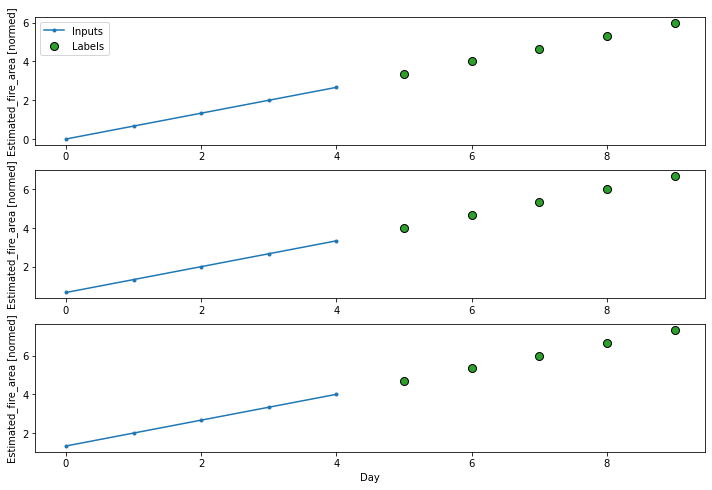

In [27]:
OUT_STEPS = 5
multi_window = WindowGenerator(input_width=5,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,label_columns=['Estimated_fire_area'])

multi_window.plot()
multi_window

In [28]:
# Each element is an (inputs, label) pair
multi_window.train.element_spec

(TensorSpec(shape=(None, 5, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None))

In [29]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Dense(20),
    tf.keras.layers.GRU(50, return_sequences=True, return_state=False),
    tf.keras.layers.GRU(50), 
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS,1])
                          )])

In [30]:
history2 = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/100
13/13 [==============================] - 0s 34ms/step - loss: 6399.6045 - mean_absolute_error: 70.3437 - val_loss: 25452.2715 - val_mean_absolute_error: 159.2306
Epoch 2/100
13/13 [==============================] - 0s 9ms/step - loss: 6168.9668 - mean_absolute_error: 68.5949 - val_loss: 24994.0312 - val_mean_absolute_error: 157.7851
Epoch 3/100
13/13 [==============================] - 0s 9ms/step - loss: 6003.9004 - mean_absolute_error: 67.3119 - val_loss: 24655.3242 - val_mean_absolute_error: 156.7074
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: 5880.1382 - mean_absolute_error: 66.3403 - val_loss: 24390.7246 - val_mean_absolute_error: 155.8602
Epoch 5/100
13/13 [==============================] - 0s 9ms/step - loss: 5778.6821 - mean_absolute_error: 65.5569 - val_loss: 24164.4258 - val_mean_absolute_error: 155.1324
Epoch 6/100
13/13 [==============================] - 0s 8ms/step - loss: 5688.3208 - mean_absolute_error: 64.8748 - val_loss: 23955.10

13/13 [==============================] - 0s 7ms/step - loss: 3269.5791 - mean_absolute_error: 45.0498 - val_loss: 17614.0059 - val_mean_absolute_error: 132.3483
Epoch 49/100
13/13 [==============================] - 0s 7ms/step - loss: 3230.8015 - mean_absolute_error: 45.0633 - val_loss: 17492.9590 - val_mean_absolute_error: 131.8902
Epoch 50/100
13/13 [==============================] - 0s 7ms/step - loss: 3188.9783 - mean_absolute_error: 44.5818 - val_loss: 17371.5195 - val_mean_absolute_error: 131.4291
Epoch 51/100
13/13 [==============================] - 0s 7ms/step - loss: 3154.1292 - mean_absolute_error: 44.7160 - val_loss: 17253.1035 - val_mean_absolute_error: 130.9778
Epoch 52/100
13/13 [==============================] - 0s 8ms/step - loss: 3108.4702 - mean_absolute_error: 43.5546 - val_loss: 17134.8613 - val_mean_absolute_error: 130.5257
Epoch 53/100
13/13 [==============================] - 0s 8ms/step - loss: 3070.6216 - mean_absolute_error: 43.5000 - val_loss: 17016.2637 - val

Epoch 95/100
13/13 [==============================] - 0s 7ms/step - loss: 1821.4460 - mean_absolute_error: 31.2619 - val_loss: 12853.0469 - val_mean_absolute_error: 112.9402
Epoch 96/100
13/13 [==============================] - 0s 7ms/step - loss: 1799.9967 - mean_absolute_error: 31.1430 - val_loss: 12768.0752 - val_mean_absolute_error: 112.5635
Epoch 97/100
13/13 [==============================] - 0s 8ms/step - loss: 1786.0979 - mean_absolute_error: 31.6462 - val_loss: 12687.1250 - val_mean_absolute_error: 112.2034
Epoch 98/100
13/13 [==============================] - 0s 7ms/step - loss: 1755.1431 - mean_absolute_error: 30.4623 - val_loss: 12603.8848 - val_mean_absolute_error: 111.8318
Epoch 99/100
13/13 [==============================] - 0s 7ms/step - loss: 1736.6669 - mean_absolute_error: 30.5720 - val_loss: 12523.4512 - val_mean_absolute_error: 111.4717
Epoch 100/100
13/13 [==============================] - 0s 7ms/step - loss: 1711.6534 - mean_absolute_error: 29.9159 - val_loss: 12

In [31]:
multi_lstm_model.predict(multi_window.val)

array([[[49.581097],
        [49.646473],
        [51.149353],
        [51.34491 ],
        [49.42942 ]],

       [[49.581097],
        [49.646473],
        [51.149357],
        [51.34491 ],
        [49.429424]],

       [[49.581097],
        [49.646473],
        [51.149357],
        [51.34491 ],
        [49.42943 ]],

       [[49.5811  ],
        [49.646473],
        [51.14936 ],
        [51.34491 ],
        [49.429424]],

       [[49.581097],
        [49.646473],
        [51.149353],
        [51.34491 ],
        [49.42942 ]],

       [[49.581097],
        [49.646473],
        [51.149357],
        [51.34491 ],
        [49.42943 ]],

       [[49.581097],
        [49.646473],
        [51.149357],
        [51.34491 ],
        [49.42943 ]],

       [[49.5811  ],
        [49.646473],
        [51.149353],
        [51.34491 ],
        [49.429424]],

       [[49.581097],
        [49.646473],
        [51.149353],
        [51.34491 ],
        [49.429424]],

       [[49.581097],
        [49.6464

When I change to GRU instead of LSTM, it works better.

4/4 [==============================] - 0s 2ms/step - loss: 12441.4072 - mean_absolute_error: 111.1031


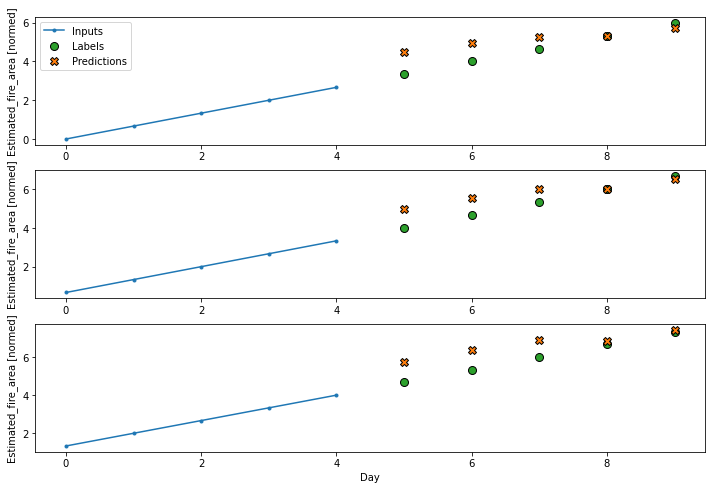

In [32]:
val_performance['M_LSTM'] = multi_lstm_model.evaluate(multi_window.val)
performance['M_LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [33]:
CONV_WIDTH = 5
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_conv_model, multi_window)

Epoch 1/100
13/13 [==============================] - 0s 11ms/step - loss: 5053.4941 - mean_absolute_error: 63.7806 - val_loss: 15332.1787 - val_mean_absolute_error: 123.5944
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 1604.6564 - mean_absolute_error: 37.4134 - val_loss: 1972.1246 - val_mean_absolute_error: 44.3301
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 120.3658 - mean_absolute_error: 8.8951 - val_loss: 721.1356 - val_mean_absolute_error: 26.7888
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 45.2140 - mean_absolute_error: 5.9649 - val_loss: 31.0440 - val_mean_absolute_error: 5.4627
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 26.2893 - mean_absolute_error: 4.7809 - val_loss: 35.9773 - val_mean_absolute_error: 5.9341
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 6.4484 - mean_absolute_error: 2.2596 - val_loss: 23.6844 - val_mean_absolute_error: 

13/13 [==============================] - 0s 5ms/step - loss: 115.3180 - mean_absolute_error: 9.4664 - val_loss: 55.8625 - val_mean_absolute_error: 7.4454
Epoch 49/100
13/13 [==============================] - 0s 5ms/step - loss: 64.7875 - mean_absolute_error: 6.6239 - val_loss: 47.5831 - val_mean_absolute_error: 6.8382
Epoch 50/100
13/13 [==============================] - 0s 5ms/step - loss: 49.9321 - mean_absolute_error: 6.4275 - val_loss: 13.6086 - val_mean_absolute_error: 3.6379
Epoch 51/100
13/13 [==============================] - 0s 5ms/step - loss: 32.5242 - mean_absolute_error: 4.7671 - val_loss: 27.7885 - val_mean_absolute_error: 5.2052
Epoch 52/100
13/13 [==============================] - 0s 5ms/step - loss: 25.5673 - mean_absolute_error: 4.7443 - val_loss: 2.7534 - val_mean_absolute_error: 1.5365
Epoch 53/100
13/13 [==============================] - 0s 5ms/step - loss: 18.9007 - mean_absolute_error: 3.6944 - val_loss: 17.7057 - val_mean_absolute_error: 4.1333
Epoch 54/100
13/1

In [34]:
multi_conv_model.predict(multi_window.val)

array([[[146.27898],
        [147.28856],
        [148.29816],
        [149.30785],
        [150.31767]],

       [[146.96655],
        [147.98082],
        [148.99507],
        [150.00945],
        [151.02393]],

       [[147.65414],
        [148.67305],
        [149.69196],
        [150.71098],
        [151.73016]],

       [[148.34174],
        [149.36531],
        [150.38889],
        [151.41257],
        [152.43642]],

       [[149.02936],
        [150.05754],
        [151.08578],
        [152.11414],
        [153.14267]],

       [[149.71692],
        [150.7498 ],
        [151.78268],
        [152.81575],
        [153.8489 ]],

       [[150.40451],
        [151.44203],
        [152.47961],
        [153.51732],
        [154.55516]],

       [[151.0921 ],
        [152.1343 ],
        [153.17654],
        [154.21892],
        [155.26143]],

       [[151.77966],
        [152.82654],
        [153.87344],
        [154.92047],
        [155.9677 ]],

       [[152.46725],
        [153.518

4/4 [==============================] - 0s 1ms/step - loss: 19.8830 - mean_absolute_error: 4.3878


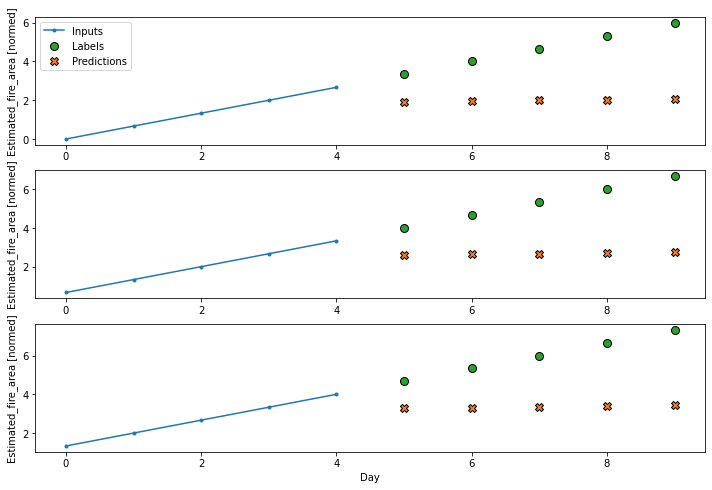

In [35]:
val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

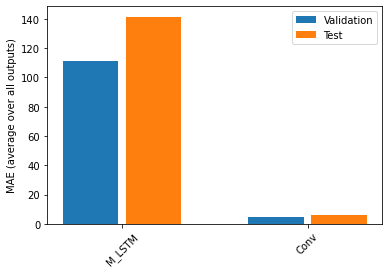

In [36]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [37]:
for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (16, 5, 3)
Labels shape (batch, time, features): (16, 5, 1)
